In [1]:
#loading the preprocessed data
from google.colab import files
upload = files.upload()

Saving Modified_SQL_Dataset.csv to Modified_SQL_Dataset.csv


In [3]:
import pandas as pd
df = pd.read_csv("csic_extracted.csv")
df.drop('Unnamed: 0',axis = 1, inplace=True)


In [4]:
df

,content,classification
0,http://localhost:8080/tienda1/index.jsp HTTP/1.1,0
1,http://localhost:8080/tienda1/publico/anadir.j...,0
2,http://localhost:8080/tienda1/publico/anadir.j...,0
3,http://localhost:8080/tienda1/publico/autentic...,0
4,http://localhost:8080/tienda1/publico/autentic...,0
...,...,...
61060,http://localhost:8080/tienda1/miembros/editar....,1
61061,http://localhost:8080/tienda1/miembros/editar....,1
61062,http://localhost:8080/tienda1/miembros/editar....,1
61063,http://localhost:8080/tienda1/imagenes/3.gif/ ...,1


In [5]:
import pandas as pd
import json
import urllib.parse
import base64

# decode function definition
def decode_sql(encoded_string):
    # decode ASCII
    try:
        decoded_string = bytes.fromhex(encoded_string).decode('ascii')
    except:
        pass

    #  decode Unicode
    try:
        decoded_string = bytes.fromhex(encoded_string).decode('unicode_escape')
    except:
        pass

    # decode JSON
    try:
        decoded_string = json.loads(encoded_string)
    except:
        pass

    # decode URL
    try:
        decoded_string = urllib.parse.unquote(encoded_string)
    except:
        pass

    # decode Base64
    try:
        decoded_string = base64.b64decode(encoded_string).decode('utf-8')
    except:
        pass

    return decoded_string

import pandas as pd
import re

# Chuyển sang chữ thường
def lowercase_sql(query):
    return query.lower()

# Hàm xử lý được tổng quát hóa (generalized processing function)
def generalize_sql(query):
    # Replace all digits with ‘0’
    generalized_query = re.sub(r'\d+', '0', query)
    return generalized_query

# Hàm phân đoạn từ
def tokenize_sql(query):
    # Thêm dấu cách trước và sau các ký tự < , > hoặc =
    query = re.sub(r'([<>!=])', r' \1 ', query)
    # Sử dụng dấu cách để phân tách các từ
    tokens = query.split()
    return ' '.join(tokens)

# Xử lý cột Truy vấn và tạo cột mới text
df['Text'] = df['content'].apply(decode_sql)  # Quá trình giải mã
df['Text'] = df['Text'].apply(lowercase_sql)  # đồng nhất chữ thường
df['Text'] = df['Text'].apply(generalize_sql)  # Generalization, tổng quát hóa
df['Text'] = df['Text'].apply(tokenize_sql)  # Phân đoạn từ

print(df.head())


                                             content  classification  \
0   http://localhost:8080/tienda1/index.jsp HTTP/1.1               0   
1  http://localhost:8080/tienda1/publico/anadir.j...               0   
2  http://localhost:8080/tienda1/publico/anadir.j...               0   
3  http://localhost:8080/tienda1/publico/autentic...               0   
4  http://localhost:8080/tienda1/publico/autentic...               0   

                                                Text  
0      http://localhost:0/tienda0/index.jsp http/0.0  
1  http://localhost:0/tienda0/publico/anadir.jsp?...  
2  http://localhost:0/tienda0/publico/anadir.jsp ...  
3  http://localhost:0/tienda0/publico/autenticar....  
4  http://localhost:0/tienda0/publico/autenticar....  


In [6]:
## train test split 80%/20%
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.20,random_state=50,shuffle=True)

train_df

,content,classification,Text
55963,http://localhost:8080/tienda1/publico/pagar.js...,1,http://localhost:0/tienda0/publico/pagar.jsp?m...
16827,http://localhost:8080/tienda1/publico/registro...,0,http://localhost:0/tienda0/publico/registro.js...
24274,http://localhost:8080/tienda1/publico/miembros...,0,http://localhost:0/tienda0/publico/miembros.js...
41222,http://localhost:8080/tienda1/publico/registro...,1,http://localhost:0/tienda0/publico/registro.js...
31774,http://localhost:8080/tienda1/miembros/imagene...,0,http://localhost:0/tienda0/miembros/imagenes/c...
...,...,...,...
48417,http://localhost:8080/tienda1/publico/entrar.j...,1,http://localhost:0/tienda0/publico/entrar.jsp?...
22637,http://localhost:8080/tienda1/miembros/salir.j...,0,http://localhost:0/tienda0/miembros/salir.jsp ...
42891,http://localhost:8080/tienda1/publico/anadir.j...,1,http://localhost:0/tienda0/publico/anadir.jsp?...
38368,http://localhost:8080/tienda1/publico/caracter...,1,http://localhost:0/tienda0/publico/caracterist...


In [8]:
train_texts, train_labels = train_df['Text'].tolist(), train_df['classification'].tolist()
test_texts, test_labels = test_df['Text'].tolist(), test_df['classification'].tolist()

### Bert LSTM model

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel

# Tự định nghĩa lớp dữ liệu tùy chỉnh, tạo ra một lớp (class) trong PyTorch để tùy chỉnh cách dữ liệu được tải và xử lý
#cần triển khai phương thức __len__ để trả về kích thước của tập dữ liệu và __getitem__ để truy xuất dữ liệu tại một chỉ mục cụ thể

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): #__ magic method, nạp chồng toán tử
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

################### mô hình BERT+TextCNN
class BertTextCNNClassifier(nn.Module):
    def __init__(self, bert_model, num_filters, filter_sizes, output_size):
        super(BertTextCNNClassifier, self).__init__()
        self.bert_model = bert_model
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=bert_model.config.hidden_size, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)

        # Transpose to fit the Conv1d input format (batch_size, num_channels, seq_len)
        embedded = outputs.last_hidden_state.transpose(1, 2)

        # Apply convolutional layers with different kernel sizes and max-pooling
        pooled_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = nn.functional.relu(conv_layer(embedded))
            pooled_out, _ = torch.max(conv_out, dim=2)
            pooled_outputs.append(pooled_out)

        # Concatenate pooled outputs and flatten
        pooled_outputs = torch.cat(pooled_outputs, dim=1)
        pooled_outputs = self.dropout(pooled_outputs)

        # Fully connected layer for classification
        logits = self.fc(pooled_outputs)
        return logits


# Cài đặt thông số để đào tạo thuật toán
batch_size = 64
max_length = 128
hidden_size = 128
num_layers = 1
# Thiết lập số lớp (number of classified)
num_classes = 2
output_size = num_classes
bidirectional = False

# load BERT model and tokenizer
bert_model_name = 'bert-base-uncased'  # mô hình BERT đã được tiền huấn luyện, có kích thước nhỏ hơn và được huấn luyện trên văn bản không phân biệt chữ hoa và chữ thường
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

# Dataset (tập dữ liệu) và DataLoader (trình lặp dữ liệu)
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

################# Khởi tạo mô hình TextCNN
num_filters = 100
filter_sizes = [2, 3, 4]
output_size = 2  # Number of classes in your classification task
model = BertTextCNNClassifier(bert_model, num_filters, filter_sizes, output_size)
########################


# Loss Function (hàm mất mát) và Optimizer (bộ tối ưu hóa)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

num_epochs = 30  # thiết lập số lượng epoch
from tqdm import tqdm  # import tqdm library for adding progress bar

# Huấn luyện mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

print("Start training")
for epoch in range(num_epochs):
    total_loss = 0
    correct_train = 0
    total_train = 0

    # wrap train_loader with tqdm for adding progress bar
    with tqdm(train_loader, unit="batch") as t:
        for batch in t:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            t.set_postfix({'loss': total_loss / (t.n + 1), 'accuracy': correct_train / total_train})


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Test the model, kiểm tra hiệu suất của mô hình
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []

    # wrap test_loader with tqdm for adding progress bar
    with tqdm(test_loader, unit="batch") as t:
        for batch in t:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            t.set_postfix({})

# Chỉ số đánh giá, đo lường hiệu suất của mô hình
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Start training


100%|██████████| 97/97 [00:46<00:00,  2.09batch/s]

Test Accuracy: 0.9981
Precision: 0.9982
Recall: 0.9964
F1-score: 0.9973


In [25]:
#!pip install torchinfo
import torchinfo
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Word2VecTextCNNClassifier                --
├─ModuleList: 1-1                        --
│    └─Conv1d: 2-1                       20,100
│    └─Conv1d: 2-2                       30,100
│    └─Conv1d: 2-3                       40,100
├─Dropout: 1-2                           --
├─Linear: 1-3                            602
Total params: 90,902
Trainable params: 90,902
Non-trainable params: 0

In [12]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,log_loss

In [18]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1]
    plt.figure(figsize = (20,5))
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

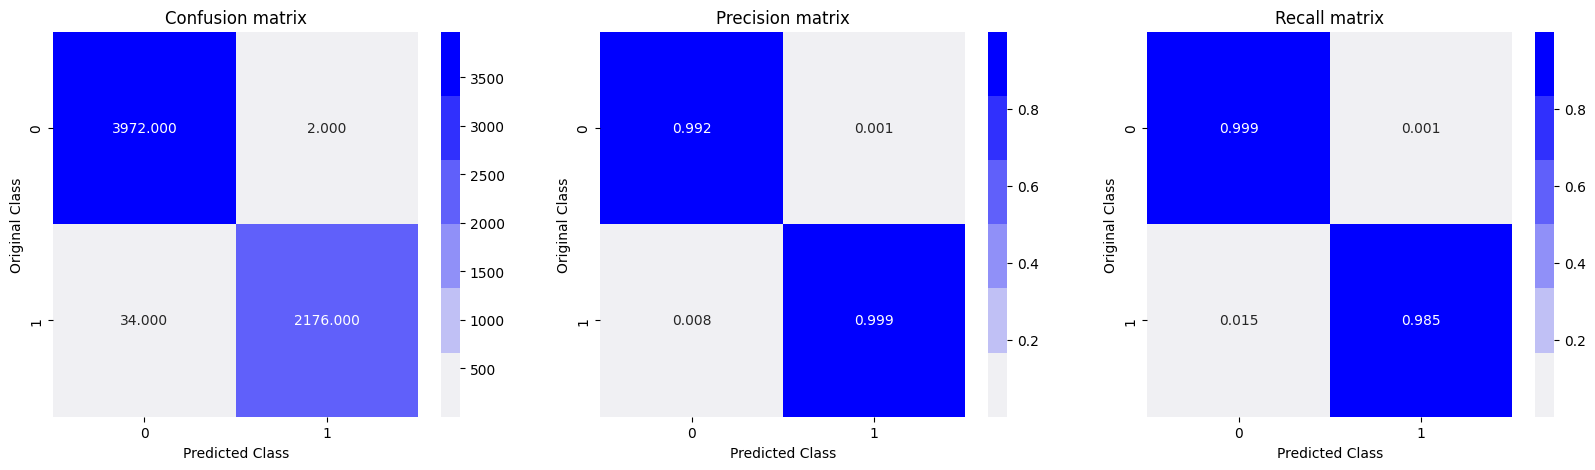

In [24]:
plot_confusion_matrix(y_true, y_pred)

In [21]:
#model.save("BertLSTMClassifier08.h5")
torch.save(model.state_dict(), 'BertCNNClassifier30eposch.pth')